# Notebook for training TopoNEt model on MEG data for predicting the task being performed

Model architecture - https://arxiv.org/pdf/1611.08024

Training data - MEG data recorder while people were performing different tasks.

In [196]:
import copy
import random

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
import torchmetrics
from pymatreader import read_mat
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold

## First experiment
0.5 seconds before the actual experiment has started. Participant is informed, what he needs to pay attention to.
Only one participant is used for training and testing.

### Loading data

In [43]:
def load_first_500ms(file_path: str, label: int) -> list:
    """
    Loads trials from a file and takes the first 500ms of data from them.
    :return: (500ms_of_trial, label) where label is ground truth for classification.
    """
    data = read_mat(file_path)
    cut_data = []
    for trial in data['finalStruct']['trial']:
        cut_trial = np.empty([0, 500])
        for sensor in trial:
            cut_trial = np.append(cut_trial, [sensor[:500]], axis=0)
        cut_data.append((np.float32(cut_trial), label))
    return cut_data

In [213]:
subject_number = '01' # We can train our models on different participants

data = load_first_500ms(f'/mnt/diska/baldauf/Subject_{subject_number}_OnsetStim_BOT_scoutTimeSeriesNew.mat', 0) + \
       load_first_500ms(f'/mnt/diska/baldauf/Subject_{subject_number}_OnsetStim_TOP_scoutTimeSeriesNew.mat', 1)

# Since we have a small amount of data, we will only use train and test
test_size = int(0.1 * len(data))
train_dataset, test_dataset = random_split(data, [len(data) - test_size, test_size])

torch.manual_seed(42) # for reproducibility
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

f'Size of training dataset - {len(data) - test_size} trials'

'Size of training dataset - 219 trials'

### Model classes

Here we implement EEGNet, but with some modifications, due to the nature of our data and need to use topographical constraints.

In [179]:
class ConstrainedConv2d(nn.Conv2d):
    """
    Implementation of maximum norm constraint for Conv2D layer
    """
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.conv2d(x, self.weight.clamp(max=1.0), self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

class ConstrainedLinear(nn.Linear):
    """
    Implementation of maximum norm constraint for Linear layer
    """
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.linear(x, self.weight.clamp(max=0.5), self.bias)

class EEGNet(nn.Module):
    def __init__(self, sensors: int, samples: int, num_classes: int, filter_size=64, f1=8, depth=2, f2=16, dropout=0.25):
        super().__init__()
        self.block1 = nn.Sequential(
            # This layer does 1d convolutions on data from sensors.
            # Since we have only 500ms of data we set kernel length at 250 (we look at 250ms at once).
            # We can capture patterns with frequency above 4Hz (because data sampling is 1000Hz, 1000 / 250 = 4).
            nn.Conv2d(in_channels=1, out_channels=f1, kernel_size=(1, filter_size), padding='same',
                      bias=False),
            nn.BatchNorm2d(f1),

            # Depthwise convolution. Looks for spatial patterns and combines all data from sensors together.
            # We use our own implementation of convolution layer because pytorch doesn't have weight constraints implemented.
            ConstrainedConv2d(in_channels=f1, out_channels=f1*depth, kernel_size=(sensors, 1), padding='valid',
                              groups=f1, bias=False),
            nn.BatchNorm2d(f1*depth),
            nn.ELU(),

            # Average pooling to reduce sampling rate
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(dropout),
        )
        self.block2 = nn.Sequential(
            # Implementation of Separable convolution.
            # First we use Depthwise convolution (separately for all channels).
            nn.Conv2d(in_channels=f1*depth, out_channels=f1*depth, kernel_size=(1, 16), padding='same',
                      groups=f1*depth, bias=False),

            # Next we combine channels with Pointwise convolution.
            nn.Conv2d(in_channels=f1*depth, out_channels=f2, kernel_size=(1, 1), bias=False),
            nn.BatchNorm2d(f2),
            nn.ELU(),

            # Average pooling to reduce sampling rate
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(dropout),
            nn.Flatten(),
        )
        # We have to add one dense layer in order to implement topographical constraints.
        # We use our own implementation again to introduce weights constraint.
        self.linear = ConstrainedLinear(in_features=f2*(samples//32), out_features=36)

        # Classifier layer
        self.classifier = nn.Linear(in_features=36, out_features=num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block1(x)
        x = self.block2(x)
        x = self.linear(x)
        return self.classifier(x)


### Sanity check
Checking, that forward pass works and model data shapes are the ones we expect

In [64]:
test_data, label = next(iter(test_loader))
test_sample = test_data[0].unsqueeze(0).unsqueeze(0)
print(f'The shape of the test sample is {test_sample.shape}')

test_model = EEGNet(sensors=test_sample.shape[2], samples=test_sample.shape[3], num_classes=2, f1=8, depth=2, f2=16, dropout=0.5)
test_model.eval()
with torch.inference_mode():
    x = test_model.block1(test_sample)
    print(f'Expected shape - (1, 16, 1, 125), we have - {x.shape}')
    x = test_model.block2(x)
    print(f'Expected shape - (1, 240), we have - {x.shape}')
    x = test_model.linear(x)
    print(f'Expected shape - (1, 36), we have - {x.shape}')
    x = test_model.classifier(x)
    print(f'Expected shape - (1, 2), we have - {x.shape}')

The shape of the test sample is torch.Size([1, 1, 360, 500])
Expected shape - (1, 16, 1, 125), we have - torch.Size([1, 16, 1, 125])
Expected shape - (1, 240), we have - torch.Size([1, 240])
Expected shape - (1, 36), we have - torch.Size([1, 36])
Expected shape - (1, 2), we have - torch.Size([1, 2])


### Spatial loss implementation
Imagines, that neurons on the layer have a spatial organization and calculates average distance between neighbouring weights associated with those neurons.

Inspired by brain neuronal organization.

In [190]:
def spatial_loss(weights: torch.Tensor, grid_width: int):
    """
    Calculates the spatial loss for a set of weights.
    :param weights: weights tensor.
    :param grid_width: width of our imagined grid. Works with any grid of rectangular shape.
    """
    # This is a transformation which helps to calculate indexes of "neighbouring" neurons.
    neighbour_transformations = np.array([-grid_width - 1, -grid_width, -grid_width + 1, -1, +1, grid_width - 1, grid_width, grid_width + 1])

    sp_loss = 0.0
    num_neighbours = 0
    for i in range(weights.shape[0]):
        # We calculate indexes and filter those out of scope.
        neighbours = neighbour_transformations + i
        neighbour_filter = (neighbours >= 0) & (neighbours < weights.shape[0]) & ~ ((i % grid_width == grid_width - 1) & (neighbours % grid_width == 0)) & ~ ((i % grid_width == 0) & (neighbours % grid_width == grid_width - 1))
        neighbours = neighbours[neighbour_filter]

        # We calculate squared distance between weights of the neuron and its neighbours.
        for neighbour in neighbours:
            distance = torch.norm(weights[i] - weights[neighbour])
            sp_loss += distance

        num_neighbours += len(neighbours)

    # We return an average distance.
    return sp_loss / num_neighbours

### Train and Test steps

In [180]:
def train_step(model, train_data, loss_fn, optimizer, lambda_regularization=0.0, spatial=False, spatial_grid_width=6):
    """
    Performs one training step.
    :param model:
    :param train_data:
    :param loss_fn:
    :param optimizer:
    :param lambda_regularization: regularization parameter for spatial loss.
    :param spatial: True, if we need to calculate spatial loss.
    :param spatial_grid_width: width of grid for spatial loss.
    :return: Average loss during the training cycle.
    """
    model.train()

    y_preds = torch.empty(0, device=DEVICE)
    y_targets = torch.empty(0, device=DEVICE)
    avg_loss = 0.0
    for X, y in train_data:
        X, y = X.to(DEVICE), y.to(DEVICE)
        X = X.unsqueeze(1)
        # Forward pass
        y_logits = model(X)
        # Performance loss
        loss = loss_fn(y_logits, y)
        # Addition of spatial loss
        if spatial:
            loss += lambda_regularization * spatial_loss(model.linear.weight, spatial_grid_width)
        # Zero gradients
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Parameters update
        optimizer.step()

        # Making predictions
        yp = torch.argmax(y_logits, dim=1)
        # Save the loss
        avg_loss += loss
        # Saving predictions
        y_preds = torch.cat((y_preds, yp), dim=0)
        # Saving targets
        y_targets = torch.cat((y_targets, y), dim=0)

    return y_preds, y_targets, avg_loss / len(train_data)

def test_step(model, test_data, loss_fn, lambda_regularization=0.0, spatial=False, spatial_grid_width=6):
    """
    Performs one test step.
    :param model:
    :param test_data:
    :param loss_fn:
    :param lambda_regularization: regularization parameter for spatial loss.
    :param spatial: True, if we need to calculate spatial loss.
    :param spatial_grid_width: width of grid for spatial loss.
    :return: model predictions on test data, targets and average loss during the test cycle.
    """
    model.eval()

    y_preds = torch.empty(0, device=DEVICE)
    y_targets = torch.empty(0, device=DEVICE)
    avg_loss = 0.0
    with torch.inference_mode():
        for X, y in test_data:
            X, y = X.to(DEVICE), y.to(DEVICE)
            X = X.unsqueeze(1)
            # Forward pass
            y_logits = model(X)
            # Performance loss
            loss = loss_fn(y_logits, y)
            # Addition of spatial loss
            if spatial:
                loss += lambda_regularization * spatial_loss(model.linear.weight, spatial_grid_width)
            # Making predictions
            yp = torch.argmax(y_logits, dim=1)
            # Saving predictions
            y_preds = torch.cat((y_preds, yp), dim=0)
            # Saving targets
            y_targets = torch.cat((y_targets, y), dim=0)

            avg_loss += loss

    return y_preds, y_targets, avg_loss / len(test_data)


### Useful functions

In [116]:
def accuracy_plot(train_acc, valid_acc):
    """
    Function to plot the change of accuracy during training.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='red', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validation accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

def loss_plot(train_loss, valid_loss):
    """
    Function to plot the change of loss during training.
    """
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='red', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='blue', linestyle='-',
        label='validation loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

### Training loop

In [200]:
def train_model(model, train_loader, test_loader, epochs, loss_fn, optimizer,
                spatial=False, lambda_regularization=0.0, spatial_grid_width=6):

    # Since dataset is more or less balanced, we will use accuracy metric
    accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=2).to(DEVICE)
    best_loss = float('inf')
    best_checkpoint = {}
    loss_history = {
        'train_loss': [],
        'valid_loss': [],
    }
    for epoch in tqdm(range(epochs)):

        predictions, targets, train_loss = train_step(model, train_loader, loss_fn, optimizer, lambda_regularization=lambda_regularization,
                                spatial=spatial, spatial_grid_width=spatial_grid_width)

        train_acc = accuracy(predictions, targets)

        predictions, targets, test_loss = test_step(model, test_loader, loss_fn, lambda_regularization=lambda_regularization,
                                                    spatial=spatial, spatial_grid_width=spatial_grid_width)
        test_acc = accuracy(predictions, targets)

        print(f'After epoch {epoch}, average training loss is {train_loss:.4f}, average test loss is {test_loss:.4f}, accuracy on train set is {train_acc * 100:.2f} and accuracy on test set is {test_acc * 100:.2f}%')

        loss_history['train_loss'].append(train_loss.item())
        loss_history['valid_loss'].append(test_loss.item())

        # Saving model with the lowest test loss
        if test_loss < best_loss:
            best_loss = test_loss
            best_checkpoint = {
                'epoch': epoch,
                'state_dict': copy.deepcopy(model.state_dict()),
                'accuracy': test_acc,
                'loss': test_loss,
            }

    return best_checkpoint, loss_history

### Cross-validation loop

In [206]:
def train_with_cross_validation(model_class, model_params: dict, data, epochs, random_seed=42):
    """
    Function to train several models using 10-fold cross validation.
    :param model_class: class of model we want to train.
    :param model_params: parameters for models. ['model'] - parameters of model, ['spatial'] - parameters for spatial component.
    :param data:
    :param epochs:
    :param random_seed:
    :return: trained models with additional information.
    """
    accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=2).to(DEVICE)

    # Prepare data
    test_size = int(0.1 * len(data))
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    dataset, test_dataset = random_split(data, [len(data) - test_size, test_size])
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

    resulting_models = []
    # Prepare folds
    kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)
    for train_idx, val_idx in tqdm(kfold.split(dataset), total=10):
        # Prepare data loaders
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=64, shuffle=False)
        validation_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

        # Train one model. We get the best checkpoint
        model = model_class(**model_params['model']).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        loss_fn = torch.nn.CrossEntropyLoss()
        best_checkpoint, loss_history = train_model(model, train_loader, validation_loader, epochs, loss_fn, optimizer, **model_params['spatial'])

        # Load the best checkpoint
        model = model_class(**model_params['model']).to(DEVICE)
        model.load_state_dict(best_checkpoint['state_dict'])
        model.eval()

        # Test the best checkpoint and save results
        predictions, targets, test_loss = test_step(model, test_loader, loss_fn, **model_params['spatial'])
        test_acc = accuracy(predictions, targets)
        resulting_models.append({
            'model': copy.deepcopy(model.state_dict()),
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'epoch': best_checkpoint['epoch'],
            'loss_history': loss_history,
        })

    return resulting_models


### Training hyperparameters

In [127]:
RANDOM_SEED = 42 # For reproducibility. To later models with different random initializations.
SPATIAL_REGULARIZATION = 0.3 # I'm using same regularization as in previous experiment
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### EEGNet without spatial loss

Initialization

In [134]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = EEGNet(sensors=360, samples=500, num_classes=2, f1=8, depth=2, f2=16, dropout=0.5).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training

In [135]:
best_model, loss_history = train_model(model, train_loader, test_loader, epochs=50, loss_fn=loss_fn, optimizer=optimizer)

  0%|          | 0/50 [00:00<?, ?it/s]

After epoch 0, average training loss is 0.6954, average test loss is 0.6912 and accuracy on test set is 54.17%
After epoch 1, average training loss is 0.6948, average test loss is 0.6914 and accuracy on test set is 54.17%
After epoch 2, average training loss is 0.6966, average test loss is 0.6917 and accuracy on test set is 54.17%
After epoch 3, average training loss is 0.6890, average test loss is 0.6920 and accuracy on test set is 54.17%
After epoch 4, average training loss is 0.6992, average test loss is 0.6921 and accuracy on test set is 54.17%
After epoch 5, average training loss is 0.6912, average test loss is 0.6920 and accuracy on test set is 54.17%
After epoch 6, average training loss is 0.6979, average test loss is 0.6920 and accuracy on test set is 54.17%
After epoch 7, average training loss is 0.6948, average test loss is 0.6928 and accuracy on test set is 54.17%
After epoch 8, average training loss is 0.6943, average test loss is 0.6922 and accuracy on test set is 54.17%
A

Results

Best model appeared at the epoch 0 with an accuracy of 54.17%


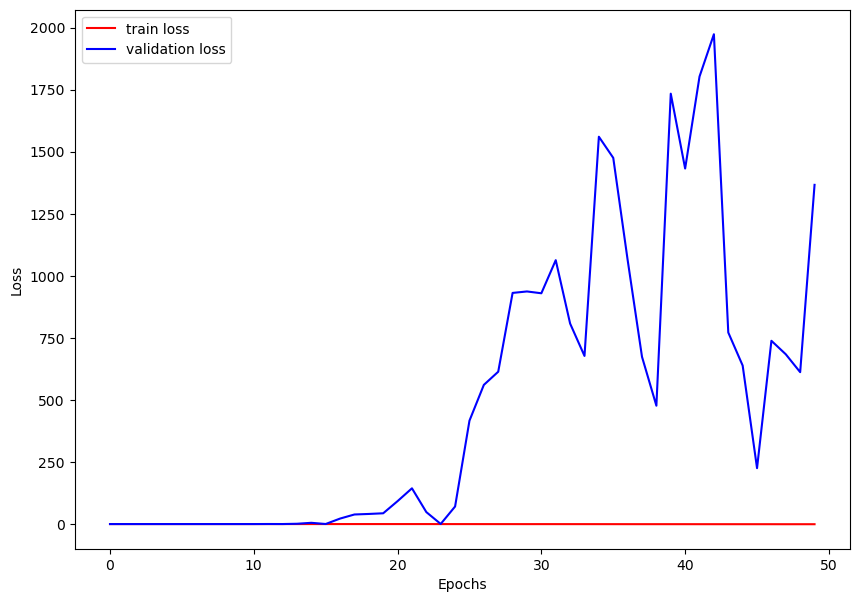

In [136]:
loss_plot(loss_history['train_loss'], loss_history['valid_loss'])

print(f'Best model appeared at the epoch {best_model["epoch"]} with an accuracy of {best_model["accuracy"] * 100:.2f}%')

### EEGNet with spatial loss

Initialization

In [137]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = EEGNet(sensors=360, samples=500, num_classes=2, f1=8, depth=2, f2=16, dropout=0.5).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training

In [138]:
best_model, loss_history = train_model(model, train_loader, test_loader, epochs=50, loss_fn=loss_fn, optimizer=optimizer,
                                       lambda_regularization=SPATIAL_REGULARIZATION, spatial=True, spatial_grid_width=6)

  0%|          | 0/50 [00:00<?, ?it/s]

After epoch 0, average training loss is 0.9262, average test loss is 0.9028 and accuracy on test set is 54.17%
After epoch 1, average training loss is 0.8941, average test loss is 0.8742 and accuracy on test set is 54.17%
After epoch 2, average training loss is 0.8663, average test loss is 0.8487 and accuracy on test set is 54.17%
After epoch 3, average training loss is 0.8365, average test loss is 0.8254 and accuracy on test set is 54.17%
After epoch 4, average training loss is 0.8206, average test loss is 0.8041 and accuracy on test set is 54.17%
After epoch 5, average training loss is 0.7961, average test loss is 0.7852 and accuracy on test set is 54.17%
After epoch 6, average training loss is 0.7819, average test loss is 0.7686 and accuracy on test set is 54.17%
After epoch 7, average training loss is 0.7635, average test loss is 0.7546 and accuracy on test set is 54.17%
After epoch 8, average training loss is 0.7523, average test loss is 0.7447 and accuracy on test set is 54.17%
A

Results

Best model appeared at the epoch 12 with an accuracy of 54.17%


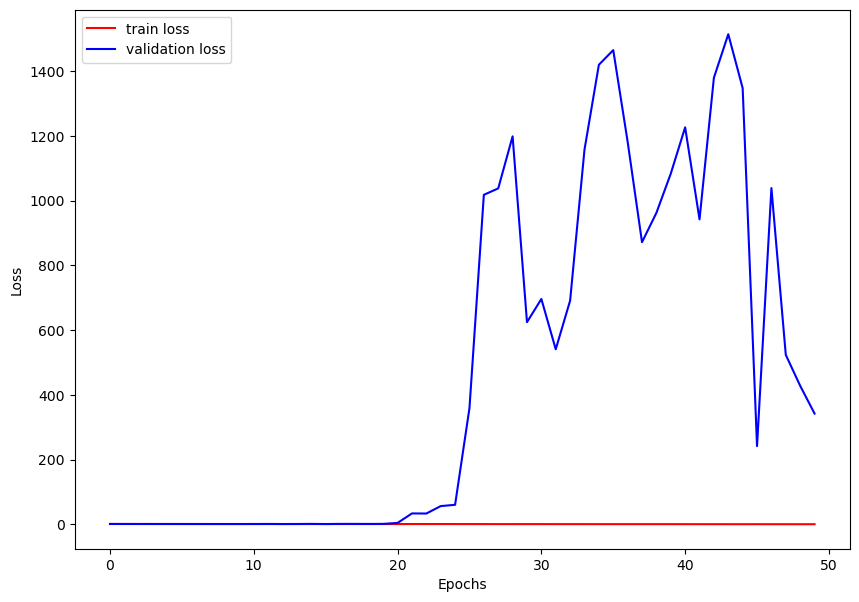

In [139]:
loss_plot(loss_history['train_loss'], loss_history['valid_loss'])

print(f'Best model appeared at the epoch {best_model["epoch"]} with an accuracy of {best_model["accuracy"] * 100:.2f}%')

### Sanity check - synthetic dataset
We create synthetic dataset with different sine patterns in order to check, if our model can learn at all.

In [167]:
pattern_freq_1 = [32, 40, 64] # Sine frequencies for the first pattern
pattern_freq_2 = [41, 57, 73] # Sine frequencies for the second pattern

synthetic_dataset = []
for _ in range(500): # Amount of data for the first pattern
    trial = np.empty([0, 200])
    for _ in range(100):
        start = random.random() * np.pi # To start from random phase
        time = np.linspace(start, start + np.pi, 200)
        data = np.zeros(200)
        for pattern in pattern_freq_1:
            data += np.sin(2 * np.pi * pattern * time) # Here we sum sine patterns together
        data = np.reshape(data, (1, 200))
        trial = np.append(trial, data, axis=0)
    synthetic_dataset.append((np.float32(trial), 0))

for _ in range(500): # Same for the second pattern
    trial = np.empty([0, 200])
    for _ in range(100):
        start = random.random() * np.pi
        time = np.linspace(start, start + np.pi, 200)
        data = np.zeros(200)
        for pattern in pattern_freq_2:
            data += np.sin(2 * np.pi * pattern * time)
        data = np.reshape(data, (1, 200))
        trial = np.append(trial, data, axis=0)
    synthetic_dataset.append((np.float32(trial), 1))

syn_train_dataset, syn_test_dataset = random_split(synthetic_dataset, [len(synthetic_dataset) - test_size, test_size])

syn_train_loader = DataLoader(syn_train_dataset, batch_size=32, shuffle=True)
syn_test_loader = DataLoader(syn_test_dataset, batch_size=32)

In [168]:
model = EEGNet(sensors=100, samples=200, num_classes=2, f1=8, depth=2, f2=16, dropout=0.5).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [169]:
best_model, loss_history = train_model(model, syn_train_loader, syn_test_loader, epochs=5, loss_fn=loss_fn, optimizer=optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

After epoch 0, average training loss is 0.3370, average test loss is 0.0575 and accuracy on test set is 100.00%
After epoch 1, average training loss is 0.0123, average test loss is 0.0023 and accuracy on test set is 100.00%
After epoch 2, average training loss is 0.0027, average test loss is 0.0013 and accuracy on test set is 100.00%
After epoch 3, average training loss is 0.0018, average test loss is 0.0008 and accuracy on test set is 100.00%
After epoch 4, average training loss is 0.0014, average test loss is 0.0008 and accuracy on test set is 100.00%


Best model appeared at the epoch 3 with an accuracy of 100.00%


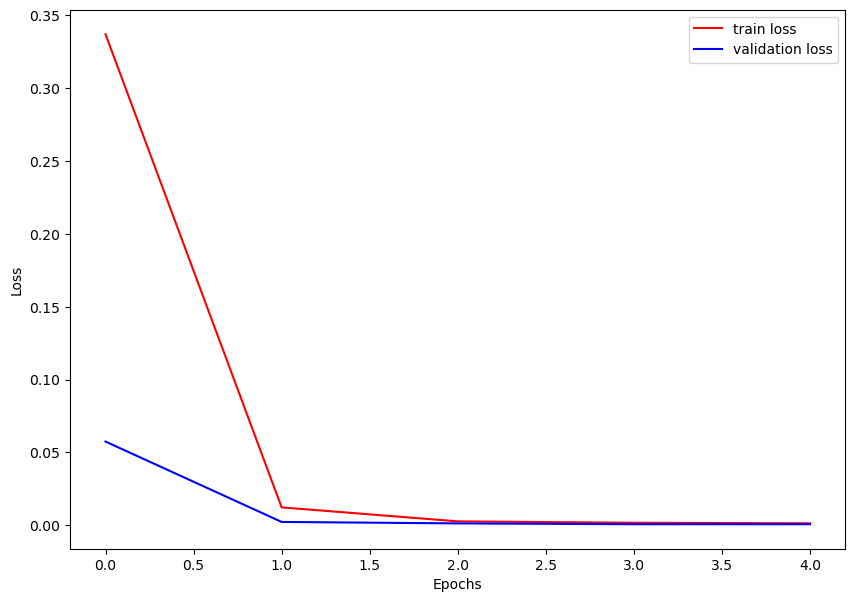

In [170]:
loss_plot(loss_history['train_loss'], loss_history['valid_loss'])

print(f'Best model appeared at the epoch {best_model["epoch"]} with an accuracy of {best_model["accuracy"] * 100:.2f}%')

## Testing with cross-validation

In [211]:
parameters = {
    'model': {
        'sensors': 360,
        'samples': 500,
        'num_classes': 2
    },
    'spatial': {
        'spatial': False
    }
}

ensemble = train_with_cross_validation(EEGNet, parameters, data, epochs=5)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

After epoch 0, average training loss is 0.7040, average test loss is 0.6961, accuracy on train set is 50.76 and accuracy on test set is 50.00%
After epoch 1, average training loss is 0.7094, average test loss is 0.6947, accuracy on train set is 54.31 and accuracy on test set is 50.00%
After epoch 2, average training loss is 0.7116, average test loss is 0.6972, accuracy on train set is 51.78 and accuracy on test set is 50.00%
After epoch 3, average training loss is 0.7095, average test loss is 0.6988, accuracy on train set is 49.75 and accuracy on test set is 50.00%
After epoch 4, average training loss is 0.6872, average test loss is 0.6988, accuracy on train set is 51.78 and accuracy on test set is 50.00%


  0%|          | 0/5 [00:00<?, ?it/s]

After epoch 0, average training loss is 0.7014, average test loss is 0.6994, accuracy on train set is 55.84 and accuracy on test set is 45.45%
After epoch 1, average training loss is 0.7055, average test loss is 0.7223, accuracy on train set is 47.21 and accuracy on test set is 45.45%
After epoch 2, average training loss is 0.7528, average test loss is 0.7267, accuracy on train set is 46.19 and accuracy on test set is 45.45%
After epoch 3, average training loss is 0.7172, average test loss is 0.6910, accuracy on train set is 47.72 and accuracy on test set is 54.55%
After epoch 4, average training loss is 0.7030, average test loss is 0.6950, accuracy on train set is 48.73 and accuracy on test set is 54.55%


  0%|          | 0/5 [00:00<?, ?it/s]

After epoch 0, average training loss is 0.7360, average test loss is 0.6818, accuracy on train set is 49.24 and accuracy on test set is 59.09%
After epoch 1, average training loss is 0.7136, average test loss is 0.6847, accuracy on train set is 45.18 and accuracy on test set is 59.09%
After epoch 2, average training loss is 0.7076, average test loss is 0.6868, accuracy on train set is 47.21 and accuracy on test set is 59.09%
After epoch 3, average training loss is 0.7156, average test loss is 0.6826, accuracy on train set is 46.70 and accuracy on test set is 59.09%
After epoch 4, average training loss is 0.6774, average test loss is 0.6793, accuracy on train set is 51.78 and accuracy on test set is 59.09%


  0%|          | 0/5 [00:00<?, ?it/s]

After epoch 0, average training loss is 0.7110, average test loss is 0.6844, accuracy on train set is 47.21 and accuracy on test set is 59.09%
After epoch 1, average training loss is 0.7157, average test loss is 0.6801, accuracy on train set is 51.27 and accuracy on test set is 59.09%
After epoch 2, average training loss is 0.7040, average test loss is 0.6786, accuracy on train set is 53.30 and accuracy on test set is 59.09%
After epoch 3, average training loss is 0.6840, average test loss is 0.6787, accuracy on train set is 49.24 and accuracy on test set is 59.09%
After epoch 4, average training loss is 0.6984, average test loss is 0.6768, accuracy on train set is 47.21 and accuracy on test set is 59.09%


  0%|          | 0/5 [00:00<?, ?it/s]

After epoch 0, average training loss is 0.6885, average test loss is 0.7058, accuracy on train set is 47.21 and accuracy on test set is 36.36%
After epoch 1, average training loss is 0.7377, average test loss is 0.7349, accuracy on train set is 51.78 and accuracy on test set is 36.36%
After epoch 2, average training loss is 0.6970, average test loss is 0.7480, accuracy on train set is 44.67 and accuracy on test set is 36.36%
After epoch 3, average training loss is 0.6940, average test loss is 0.7484, accuracy on train set is 49.24 and accuracy on test set is 36.36%
After epoch 4, average training loss is 0.6996, average test loss is 0.7252, accuracy on train set is 53.81 and accuracy on test set is 36.36%


  0%|          | 0/5 [00:00<?, ?it/s]

After epoch 0, average training loss is 0.7223, average test loss is 0.6977, accuracy on train set is 50.76 and accuracy on test set is 50.00%
After epoch 1, average training loss is 0.7454, average test loss is 0.6941, accuracy on train set is 48.22 and accuracy on test set is 50.00%
After epoch 2, average training loss is 0.7054, average test loss is 0.6946, accuracy on train set is 48.22 and accuracy on test set is 50.00%
After epoch 3, average training loss is 0.6873, average test loss is 0.6985, accuracy on train set is 50.25 and accuracy on test set is 50.00%
After epoch 4, average training loss is 0.6870, average test loss is 0.7302, accuracy on train set is 49.24 and accuracy on test set is 50.00%


  0%|          | 0/5 [00:00<?, ?it/s]

After epoch 0, average training loss is 0.7003, average test loss is 0.6891, accuracy on train set is 52.28 and accuracy on test set is 54.55%
After epoch 1, average training loss is 0.7140, average test loss is 0.6907, accuracy on train set is 53.30 and accuracy on test set is 54.55%
After epoch 2, average training loss is 0.6995, average test loss is 0.6903, accuracy on train set is 50.25 and accuracy on test set is 54.55%
After epoch 3, average training loss is 0.6954, average test loss is 0.6896, accuracy on train set is 51.27 and accuracy on test set is 54.55%
After epoch 4, average training loss is 0.6837, average test loss is 0.6995, accuracy on train set is 53.81 and accuracy on test set is 45.45%


  0%|          | 0/5 [00:00<?, ?it/s]

After epoch 0, average training loss is 0.7606, average test loss is 0.6891, accuracy on train set is 51.78 and accuracy on test set is 54.55%
After epoch 1, average training loss is 0.7540, average test loss is 0.6897, accuracy on train set is 47.72 and accuracy on test set is 54.55%
After epoch 2, average training loss is 0.7022, average test loss is 0.6901, accuracy on train set is 49.75 and accuracy on test set is 54.55%
After epoch 3, average training loss is 0.6966, average test loss is 0.6897, accuracy on train set is 50.25 and accuracy on test set is 54.55%
After epoch 4, average training loss is 0.7008, average test loss is 0.6891, accuracy on train set is 53.30 and accuracy on test set is 54.55%


  0%|          | 0/5 [00:00<?, ?it/s]

After epoch 0, average training loss is 0.6888, average test loss is 0.7069, accuracy on train set is 54.31 and accuracy on test set is 36.36%
After epoch 1, average training loss is 0.7574, average test loss is 0.7222, accuracy on train set is 48.22 and accuracy on test set is 36.36%
After epoch 2, average training loss is 0.7233, average test loss is 0.7108, accuracy on train set is 48.22 and accuracy on test set is 36.36%
After epoch 3, average training loss is 0.6796, average test loss is 0.6992, accuracy on train set is 51.78 and accuracy on test set is 36.36%
After epoch 4, average training loss is 0.6887, average test loss is 0.6781, accuracy on train set is 51.78 and accuracy on test set is 63.64%


  0%|          | 0/5 [00:00<?, ?it/s]

After epoch 0, average training loss is 0.7161, average test loss is 0.6970, accuracy on train set is 44.44 and accuracy on test set is 47.62%
After epoch 1, average training loss is 0.7195, average test loss is 0.6956, accuracy on train set is 48.99 and accuracy on test set is 47.62%
After epoch 2, average training loss is 0.6800, average test loss is 0.7029, accuracy on train set is 50.51 and accuracy on test set is 47.62%
After epoch 3, average training loss is 0.7114, average test loss is 0.6997, accuracy on train set is 46.46 and accuracy on test set is 47.62%
After epoch 4, average training loss is 0.7539, average test loss is 0.6956, accuracy on train set is 54.55 and accuracy on test set is 52.38%


Best model number is 1, loss is 0.68194580078125, accuracy is 70.83% from epoch 3


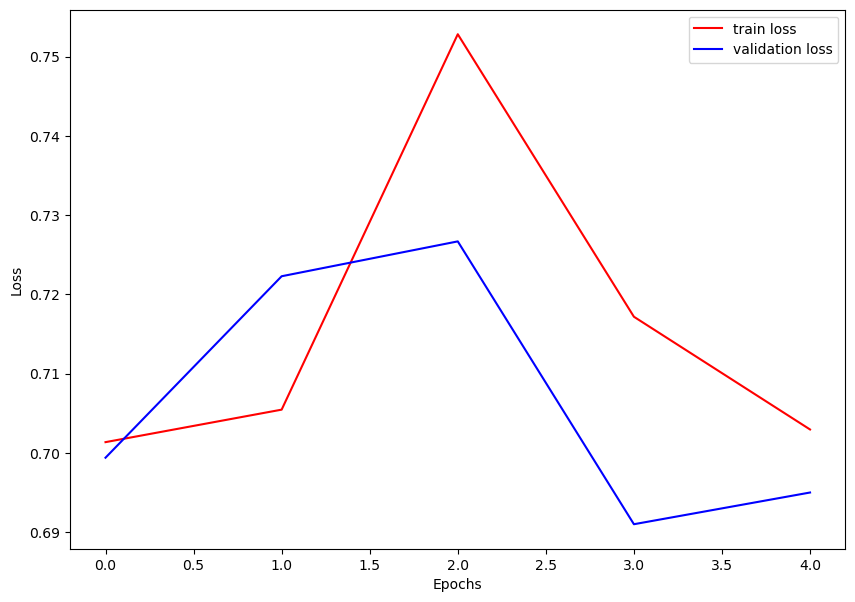

In [212]:
best_loss = float('inf')
ind = 0
for i, m in enumerate(ensemble):
    if m['test_loss'] < best_loss:
        best_loss = m['test_loss']
        ind = i

loss_plot(ensemble[ind]['loss_history']['train_loss'], ensemble[ind]['loss_history']['valid_loss'])
print(f'Best model number is {ind}, loss is {best_loss}, accuracy is {ensemble[ind]["test_accuracy"] * 100:.2f}% from epoch {ensemble[ind]["epoch"]}')

## Testing with 3 classes
More data can help us to differentiate between classes

In [214]:
parameters = {
    'model': {
        'sensors': 360,
        'samples': 500,
        'num_classes': 3
    },
    'spatial': {
        'spatial': False
    }
}

subject_number = '01'
data = load_first_500ms(f'/mnt/diska/baldauf/Subject_{subject_number}_OnsetStim_BOT_scoutTimeSeriesNew.mat', 0) + \
       load_first_500ms(f'/mnt/diska/baldauf/Subject_{subject_number}_OnsetStim_TOP_scoutTimeSeriesNew.mat', 1) + \
       load_first_500ms(f'/mnt/diska/baldauf/Subject_{subject_number}_OnsetStim_ID_scoutTimeSeriesNew.mat', 2)

ensemble = train_with_cross_validation(EEGNet, parameters, data, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

After epoch 0, average training loss is 1.1221, average test loss is 1.1055, accuracy on train set is 37.93 and accuracy on test set is 33.33%
After epoch 1, average training loss is 1.1256, average test loss is 1.1018, accuracy on train set is 34.48 and accuracy on test set is 33.33%
After epoch 2, average training loss is 1.1204, average test loss is 1.0811, accuracy on train set is 32.76 and accuracy on test set is 33.33%
After epoch 3, average training loss is 1.0988, average test loss is 1.0710, accuracy on train set is 32.41 and accuracy on test set is 45.45%
After epoch 4, average training loss is 1.1021, average test loss is 1.0865, accuracy on train set is 34.48 and accuracy on test set is 45.45%
After epoch 5, average training loss is 1.1072, average test loss is 1.1231, accuracy on train set is 32.41 and accuracy on test set is 21.21%
After epoch 6, average training loss is 1.0899, average test loss is 1.2324, accuracy on train set is 35.86 and accuracy on test set is 21.21%

  0%|          | 0/10 [00:00<?, ?it/s]

After epoch 0, average training loss is 1.1085, average test loss is 1.0985, accuracy on train set is 31.03 and accuracy on test set is 36.36%
After epoch 1, average training loss is 1.1637, average test loss is 1.0972, accuracy on train set is 27.59 and accuracy on test set is 36.36%
After epoch 2, average training loss is 1.1049, average test loss is 1.0940, accuracy on train set is 35.52 and accuracy on test set is 36.36%
After epoch 3, average training loss is 1.1001, average test loss is 1.0955, accuracy on train set is 36.90 and accuracy on test set is 36.36%
After epoch 4, average training loss is 1.1064, average test loss is 1.0973, accuracy on train set is 36.90 and accuracy on test set is 36.36%
After epoch 5, average training loss is 1.1030, average test loss is 1.1272, accuracy on train set is 36.55 and accuracy on test set is 36.36%
After epoch 6, average training loss is 1.1151, average test loss is 1.2086, accuracy on train set is 27.24 and accuracy on test set is 27.27%

  0%|          | 0/10 [00:00<?, ?it/s]

After epoch 0, average training loss is 1.1274, average test loss is 1.1020, accuracy on train set is 30.00 and accuracy on test set is 24.24%
After epoch 1, average training loss is 1.1418, average test loss is 1.0970, accuracy on train set is 35.52 and accuracy on test set is 39.39%
After epoch 2, average training loss is 1.1052, average test loss is 1.1039, accuracy on train set is 34.83 and accuracy on test set is 39.39%
After epoch 3, average training loss is 1.1154, average test loss is 1.0971, accuracy on train set is 31.38 and accuracy on test set is 39.39%
After epoch 4, average training loss is 1.1026, average test loss is 1.0936, accuracy on train set is 31.72 and accuracy on test set is 36.36%
After epoch 5, average training loss is 1.1050, average test loss is 1.0892, accuracy on train set is 33.79 and accuracy on test set is 36.36%
After epoch 6, average training loss is 1.1026, average test loss is 1.0931, accuracy on train set is 33.79 and accuracy on test set is 36.36%

  0%|          | 0/10 [00:00<?, ?it/s]

After epoch 0, average training loss is 1.1109, average test loss is 1.0911, accuracy on train set is 38.49 and accuracy on test set is 53.12%
After epoch 1, average training loss is 1.1453, average test loss is 1.0868, accuracy on train set is 30.93 and accuracy on test set is 53.12%
After epoch 2, average training loss is 1.1264, average test loss is 1.0891, accuracy on train set is 33.68 and accuracy on test set is 53.12%
After epoch 3, average training loss is 1.1115, average test loss is 1.0690, accuracy on train set is 29.21 and accuracy on test set is 53.12%
After epoch 4, average training loss is 1.1106, average test loss is 1.0834, accuracy on train set is 33.68 and accuracy on test set is 53.12%
After epoch 5, average training loss is 1.1017, average test loss is 1.1645, accuracy on train set is 33.68 and accuracy on test set is 25.00%
After epoch 6, average training loss is 1.1011, average test loss is 1.3246, accuracy on train set is 34.71 and accuracy on test set is 25.00%

  0%|          | 0/10 [00:00<?, ?it/s]

After epoch 0, average training loss is 1.1086, average test loss is 1.1007, accuracy on train set is 32.30 and accuracy on test set is 28.12%
After epoch 1, average training loss is 1.1521, average test loss is 1.0975, accuracy on train set is 29.90 and accuracy on test set is 34.38%
After epoch 2, average training loss is 1.1099, average test loss is 1.1010, accuracy on train set is 32.99 and accuracy on test set is 28.12%
After epoch 3, average training loss is 1.0973, average test loss is 1.1004, accuracy on train set is 35.40 and accuracy on test set is 28.12%
After epoch 4, average training loss is 1.0976, average test loss is 1.0926, accuracy on train set is 35.05 and accuracy on test set is 34.38%
After epoch 5, average training loss is 1.0948, average test loss is 1.1108, accuracy on train set is 34.71 and accuracy on test set is 37.50%
After epoch 6, average training loss is 1.1163, average test loss is 1.2512, accuracy on train set is 30.58 and accuracy on test set is 37.50%

  0%|          | 0/10 [00:00<?, ?it/s]

After epoch 0, average training loss is 1.0810, average test loss is 1.0743, accuracy on train set is 41.58 and accuracy on test set is 46.88%
After epoch 1, average training loss is 1.2097, average test loss is 1.0709, accuracy on train set is 28.52 and accuracy on test set is 46.88%
After epoch 2, average training loss is 1.1090, average test loss is 1.0794, accuracy on train set is 32.30 and accuracy on test set is 46.88%
After epoch 3, average training loss is 1.0950, average test loss is 1.1283, accuracy on train set is 37.11 and accuracy on test set is 21.88%
After epoch 4, average training loss is 1.1210, average test loss is 1.0533, accuracy on train set is 30.93 and accuracy on test set is 46.88%
After epoch 5, average training loss is 1.1007, average test loss is 1.0639, accuracy on train set is 34.02 and accuracy on test set is 46.88%
After epoch 6, average training loss is 1.1021, average test loss is 1.0950, accuracy on train set is 30.58 and accuracy on test set is 46.88%

  0%|          | 0/10 [00:00<?, ?it/s]

After epoch 0, average training loss is 1.1151, average test loss is 1.0984, accuracy on train set is 30.58 and accuracy on test set is 31.25%
After epoch 1, average training loss is 1.1688, average test loss is 1.1020, accuracy on train set is 29.90 and accuracy on test set is 28.12%
After epoch 2, average training loss is 1.1084, average test loss is 1.0967, accuracy on train set is 37.80 and accuracy on test set is 40.62%
After epoch 3, average training loss is 1.1010, average test loss is 1.0936, accuracy on train set is 36.08 and accuracy on test set is 40.62%
After epoch 4, average training loss is 1.0960, average test loss is 1.0918, accuracy on train set is 33.33 and accuracy on test set is 40.62%
After epoch 5, average training loss is 1.1031, average test loss is 1.1253, accuracy on train set is 32.65 and accuracy on test set is 40.62%
After epoch 6, average training loss is 1.1215, average test loss is 1.0887, accuracy on train set is 33.33 and accuracy on test set is 40.62%

  0%|          | 0/10 [00:00<?, ?it/s]

After epoch 0, average training loss is 1.0947, average test loss is 1.0986, accuracy on train set is 37.80 and accuracy on test set is 31.25%
After epoch 1, average training loss is 1.1563, average test loss is 1.1372, accuracy on train set is 27.49 and accuracy on test set is 31.25%
After epoch 2, average training loss is 1.1189, average test loss is 1.1303, accuracy on train set is 34.36 and accuracy on test set is 31.25%
After epoch 3, average training loss is 1.1039, average test loss is 1.1595, accuracy on train set is 34.36 and accuracy on test set is 31.25%
After epoch 4, average training loss is 1.1039, average test loss is 1.0897, accuracy on train set is 30.24 and accuracy on test set is 31.25%
After epoch 5, average training loss is 1.1044, average test loss is 1.0777, accuracy on train set is 36.77 and accuracy on test set is 46.88%
After epoch 6, average training loss is 1.1049, average test loss is 1.0777, accuracy on train set is 33.68 and accuracy on test set is 46.88%

  0%|          | 0/10 [00:00<?, ?it/s]

After epoch 0, average training loss is 1.1197, average test loss is 1.1067, accuracy on train set is 32.65 and accuracy on test set is 31.25%
After epoch 1, average training loss is 1.1250, average test loss is 1.1086, accuracy on train set is 34.36 and accuracy on test set is 31.25%
After epoch 2, average training loss is 1.1153, average test loss is 1.1074, accuracy on train set is 31.96 and accuracy on test set is 31.25%
After epoch 3, average training loss is 1.1110, average test loss is 1.0968, accuracy on train set is 30.58 and accuracy on test set is 37.50%
After epoch 4, average training loss is 1.0996, average test loss is 1.1418, accuracy on train set is 35.40 and accuracy on test set is 31.25%
After epoch 5, average training loss is 1.1055, average test loss is 1.3099, accuracy on train set is 32.65 and accuracy on test set is 37.50%
After epoch 6, average training loss is 1.1054, average test loss is 1.1234, accuracy on train set is 31.96 and accuracy on test set is 37.50%

  0%|          | 0/10 [00:00<?, ?it/s]

After epoch 0, average training loss is 1.1299, average test loss is 1.1023, accuracy on train set is 28.18 and accuracy on test set is 28.12%
After epoch 1, average training loss is 1.1555, average test loss is 1.1024, accuracy on train set is 28.18 and accuracy on test set is 34.38%
After epoch 2, average training loss is 1.0996, average test loss is 1.0982, accuracy on train set is 33.68 and accuracy on test set is 34.38%
After epoch 3, average training loss is 1.0952, average test loss is 1.0961, accuracy on train set is 35.74 and accuracy on test set is 34.38%
After epoch 4, average training loss is 1.0966, average test loss is 1.1036, accuracy on train set is 32.30 and accuracy on test set is 37.50%
After epoch 5, average training loss is 1.0967, average test loss is 1.4266, accuracy on train set is 32.30 and accuracy on test set is 28.12%
After epoch 6, average training loss is 1.1176, average test loss is 2.0634, accuracy on train set is 29.55 and accuracy on test set is 28.12%

Best model number is 6, loss is 1.0766668319702148, accuracy is 42.86% from epoch 6


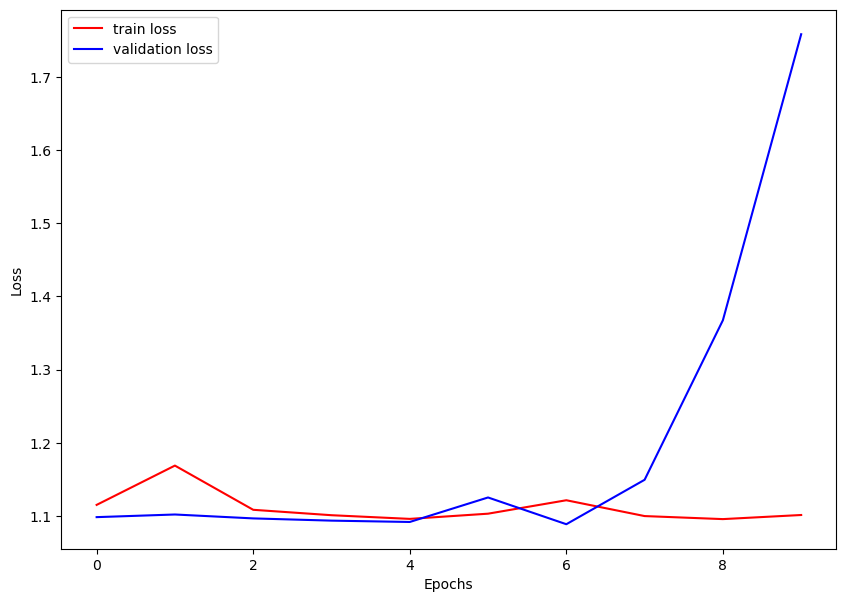

In [215]:
best_loss = float('inf')
ind = 0
for i, m in enumerate(ensemble):
    if m['test_loss'] < best_loss:
        best_loss = m['test_loss']
        ind = i

loss_plot(ensemble[ind]['loss_history']['train_loss'], ensemble[ind]['loss_history']['valid_loss'])
print(
    f'Best model number is {ind}, loss is {best_loss}, accuracy is {ensemble[ind]["test_accuracy"] * 100:.2f}% from epoch {ensemble[ind]["epoch"]}')

Possible next steps:
1. Try training with all participant data
2. Train with full data (whole experiment)
3. It would be good to train with different random seeds and try cross-validation if models will start learning something.